<a href="https://colab.research.google.com/github/esoulard47/Thyroid-Cancer-Risk-Kaggle/blob/main/Machine_Learning_Thyroid_Rick_Factor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TP 2 : Regression logistique

•	Identifiez un cas d’usage qui vous intéresse

•	Recherchez sur Google datasets search un dataset qui est en lien avec le cas d’usage

•	Analysez le dataset et identifiez une des caractéristiques à classifier

•	Préparez un notebook permettant de charger le dataset, analyse les données, afficher certaines, analyser si les données sont complètes, standardisées et normalisées

•	Préparez et nettoyez les données

•	Apprenez un modèle qui est capable de classifier de nouvelles données

•	Éléments à explorer :

•	Affichage de la courbe ROC

•	Affichage des métriques pendant l’apprentissage : précision, rappel, accuracy

•	Affichage de la matrice de confusion à la fin


# DATA SET CHOISIS : Thyroid Cancer Risk
## Source : Kaggle. com
## Lien et descriptif : https://www.kaggle.com/datasets/mzohaibzeeshan/thyroid-cancer-risk-dataset

Ce dataset comporte 212691 données concernant le cancer de la thyroide et certains facteurs de risques associés, récoltés pendant 15 ans dans une population de patients diagnostiqué pour un nodule thyroïdien.

L'objectif de l'analyse est de créer un modèle d'IA qui permet de diagnostiquer si le patient développera un cancer ou non


## 1. Chargement et analyse exploratoire des données


In [112]:
# Importer les bibliothèques
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_fscore_support, accuracy_score, classification_report
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

# Charger le dataset
df = pd.read_csv('thyroid_cancer_risk_data.csv')

# Aperçu initial des données
print("Aperçu des premières lignes:")
print(df.head())
print("\nInformations sur le dataset:")
df.info()

Aperçu des premières lignes:
   Patient_ID  Age  Gender  Country  Ethnicity Family_History  \
0           1   66    Male   Russia  Caucasian             No   
1           2   29    Male  Germany   Hispanic             No   
2           3   86    Male  Nigeria  Caucasian             No   
3           4   75  Female    India      Asian             No   
4           5   35  Female  Germany    African            Yes   

  Radiation_Exposure Iodine_Deficiency Smoking Obesity Diabetes  TSH_Level  \
0                Yes                No      No      No       No       9.37   
1                Yes                No      No      No       No       1.83   
2                 No                No      No      No       No       6.26   
3                 No                No      No      No       No       4.10   
4                Yes                No      No      No       No       9.10   

   T3_Level  T4_Level  Nodule_Size Thyroid_Cancer_Risk Diagnosis  
0      1.67      6.16         1.08          

## 17 colonnes, comportant des données numériques et catégorielles.

Les variables pertinentes pour la question posée sont Thyroid_Cancer_Risk et Diagnosis.

Nous les retirerons donc du modèle.


In [113]:
print("\nStatistiques descriptives des colonnes numériques :")
print(df.describe())


Statistiques descriptives des colonnes numériques :
         Patient_ID            Age      TSH_Level       T3_Level  \
count  212691.00000  212691.000000  212691.000000  212691.000000   
mean   106346.00000      51.918497       5.045102       2.001727   
std     61398.74739      21.632815       2.860264       0.866248   
min         1.00000      15.000000       0.100000       0.500000   
25%     53173.50000      33.000000       2.570000       1.250000   
50%    106346.00000      52.000000       5.040000       2.000000   
75%    159518.50000      71.000000       7.520000       2.750000   
max    212691.00000      89.000000      10.000000       3.500000   

            T4_Level    Nodule_Size  
count  212691.000000  212691.000000  
mean        8.246204       2.503403  
std         2.164188       1.444631  
min         4.500000       0.000000  
25%         6.370000       1.250000  
50%         8.240000       2.510000  
75%        10.120000       3.760000  
max        12.000000       5.0

## Analyse des statistiques descriptives

212691 lignes de données

La variable Patient_ID n'est pas pertinente. Je vais donc la retirer.

L'âge moyen est de 52 ans, le plus jeune patient a 15 ans, le plus âgé 89.

Les données de dosage hormonal et de taille de nodule sont cohérentes avec la réalité
(source : https://www.passeportsante.net/fr/Maux/analyses-medicales/Fiche.aspx?doc=tri-iodothyronine-libre-t3-ft3-est-taux-normal)

A noter que certains patients ne présentent pas de nodule thyroïdien. Il va falloir explorer cette donnée pour voir si elle influence les résultats globaux.

In [114]:
#retrait de la colonne 'Patient_ID'qui n'est pas pertinente
df = df.drop(columns=['Patient_ID'], errors='ignore')

#verification
print(df.columns)

# Vérification des valeurs manquantes
print("\nNombre de valeurs manquantes par colonne:")
print(df.isnull().sum())

Index(['Age', 'Gender', 'Country', 'Ethnicity', 'Family_History',
       'Radiation_Exposure', 'Iodine_Deficiency', 'Smoking', 'Obesity',
       'Diabetes', 'TSH_Level', 'T3_Level', 'T4_Level', 'Nodule_Size',
       'Thyroid_Cancer_Risk', 'Diagnosis'],
      dtype='object')

Nombre de valeurs manquantes par colonne:
Age                    0
Gender                 0
Country                0
Ethnicity              0
Family_History         0
Radiation_Exposure     0
Iodine_Deficiency      0
Smoking                0
Obesity                0
Diabetes               0
TSH_Level              0
T3_Level               0
T4_Level               0
Nodule_Size            0
Thyroid_Cancer_Risk    0
Diagnosis              0
dtype: int64


## Aucune valeur manquante, les données sont exploitables pour un modèle.

S'il y avait eu des valeurs manquantes, j'aurais arbitré selon les méthodes suivantes :

=> Variables numériques : Remplacement par la moyenne pour les colonnes numériques dont la distribution est normale et centrée autour de la moyenne

=> Variables numériques : Remplacement par la mediane pour les distributions asymétriques. Eventuellement création d'une sous-colonne si on détecte une sous population, sous réserve du volume de valeurs de cette sous-population en fonction de l'analyse de la distribution.

=> Variables catégorielles : suppression si le nombre de valeurs absentes est faible (moins de 10% du total). S'il est élevé => voir si la colonne est pertinente pour le modèle. Si oui, tester avec et sans, et recommander d'enrichir le dataset.

## ANALYSE DES DISTRIBUTIONS

## Analyse des variables catégoriques du dataset



Distribution de Gender:
Gender
Female    127527
Male       85164
Name: count, dtype: int64


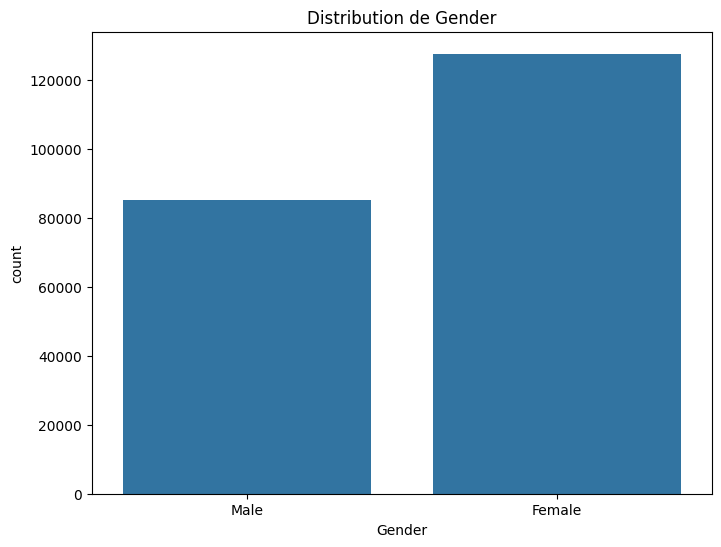


Distribution de Country:
Country
India          42496
China          31978
Nigeria        31918
Brazil         21413
Russia         21297
Japan          16867
South Korea    14965
UK             10642
USA            10558
Germany        10557
Name: count, dtype: int64


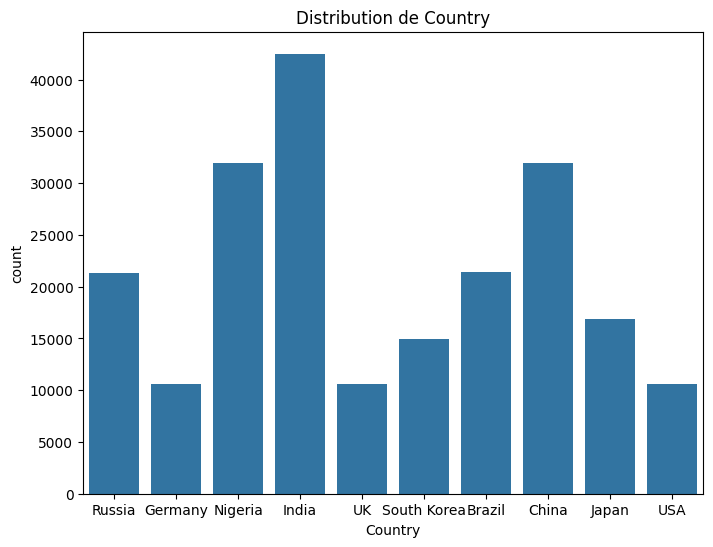


Distribution de Ethnicity:
Ethnicity
Caucasian         63669
Asian             53261
African           42414
Hispanic          32012
Middle Eastern    21335
Name: count, dtype: int64


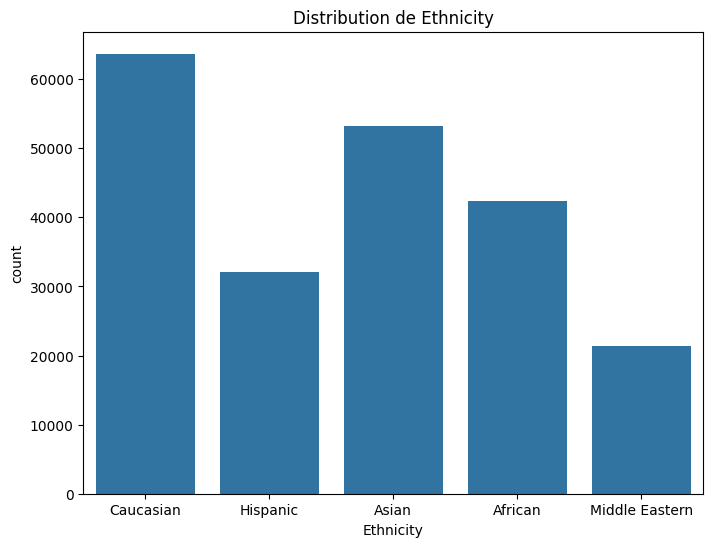


Distribution de Family_History:
Family_History
No     148866
Yes     63825
Name: count, dtype: int64


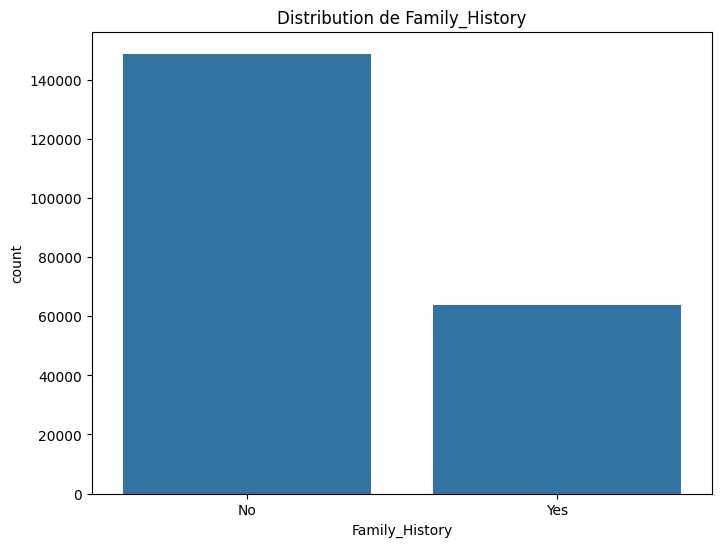


Distribution de Radiation_Exposure:
Radiation_Exposure
No     180831
Yes     31860
Name: count, dtype: int64


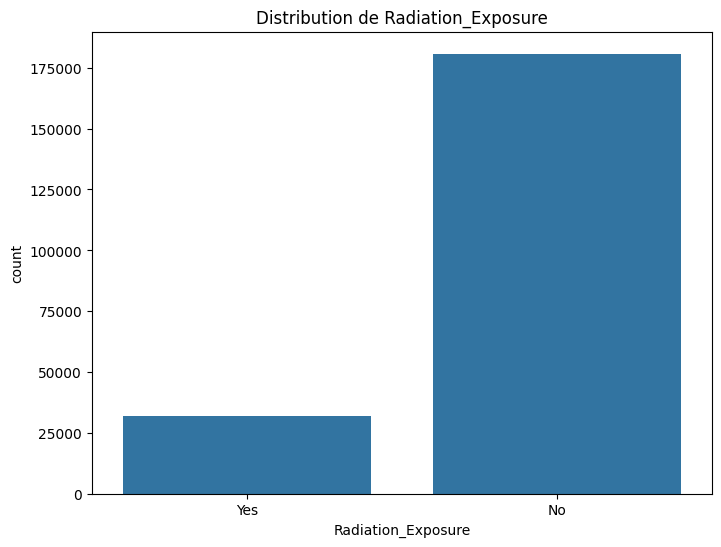


Distribution de Iodine_Deficiency:
Iodine_Deficiency
No     159673
Yes     53018
Name: count, dtype: int64


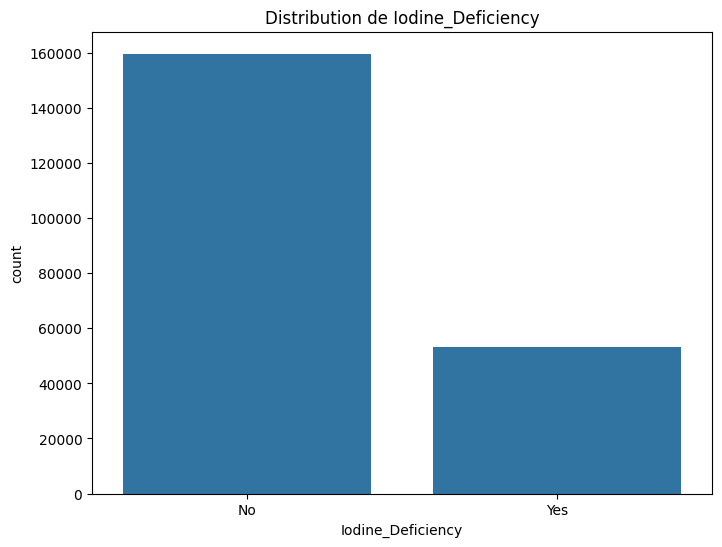


Distribution de Smoking:
Smoking
No     170260
Yes     42431
Name: count, dtype: int64


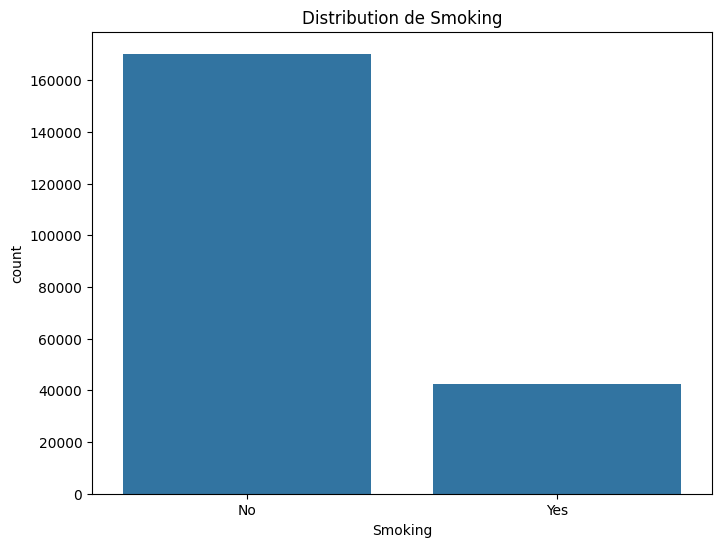


Distribution de Obesity:
Obesity
No     148805
Yes     63886
Name: count, dtype: int64


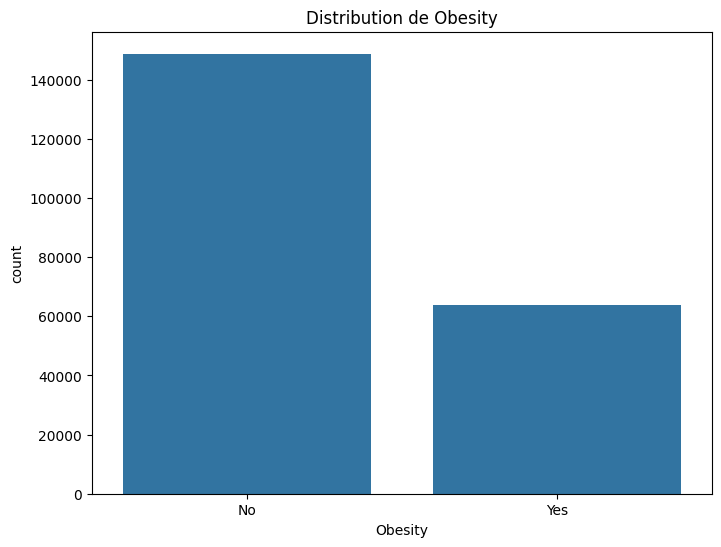


Distribution de Diabetes:
Diabetes
No     170098
Yes     42593
Name: count, dtype: int64


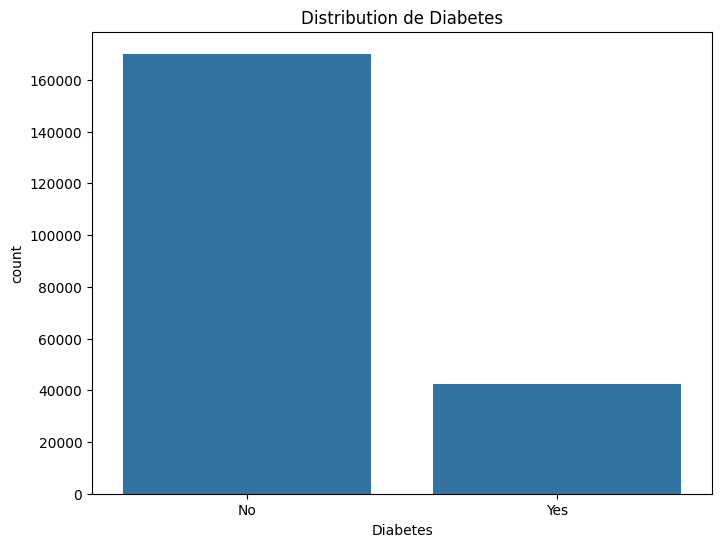

In [115]:
# Distribution des variables catégorielles
categorical_features = ['Gender', 'Country', 'Ethnicity', 'Family_History', 'Radiation_Exposure', 'Iodine_Deficiency', 'Smoking', 'Obesity', 'Diabetes']
for col in categorical_features:
    print(f"\nDistribution de {col}:")
    print(df[col].value_counts())
    plt.figure(figsize=(8, 6))
    sns.countplot(x=col, data=df)
    plt.title(f"Distribution de {col}")
    plt.show()

## Pas de déséquilibres flagrants dans les distributions à ce stade pour les variables catagorielles

## Analyse graphique des variables numériques


Distribution de Age:


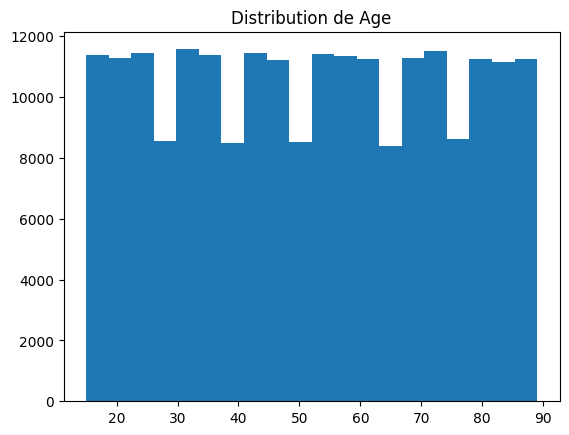


Distribution de TSH_Level:


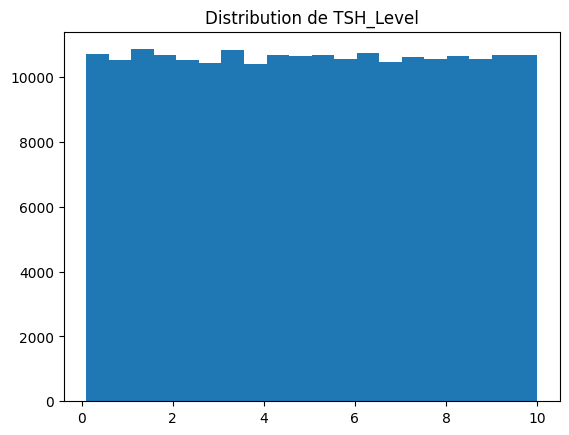


Distribution de T3_Level:


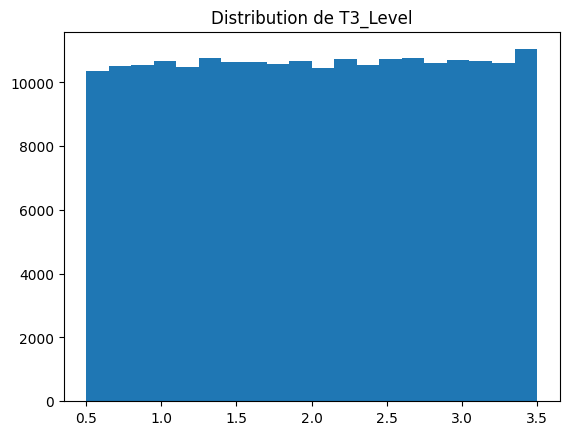


Distribution de T4_Level:


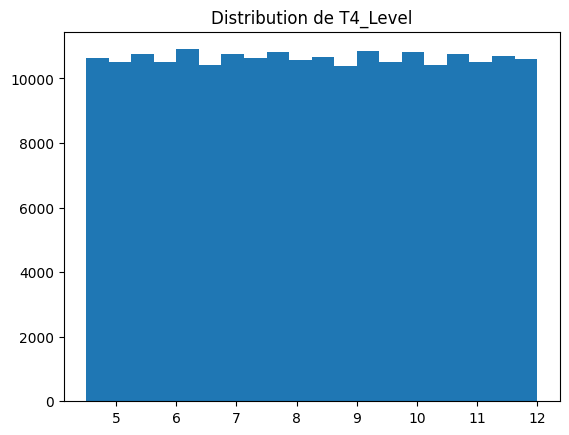


Distribution de Nodule_Size:


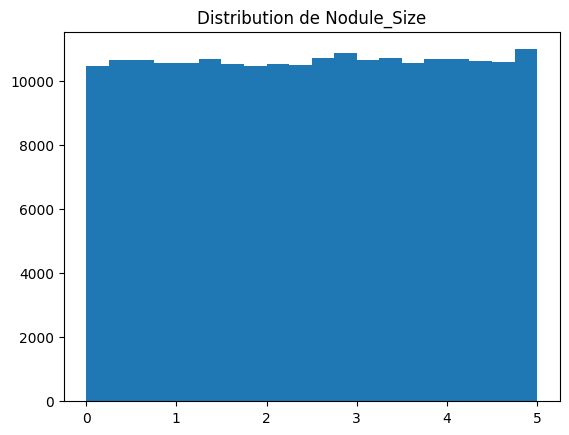

In [116]:
# Distribution des variables numériques
numerical_features = ['Age', 'TSH_Level', 'T3_Level', 'T4_Level', 'Nodule_Size']
for col in numerical_features:
    print(f"\nDistribution de {col}:")
    plt.hist(df[col], bins=20)
    plt.title(f"Distribution de {col}")
    plt.show()

## Pas de gros déséquilibres pour les variables numériques

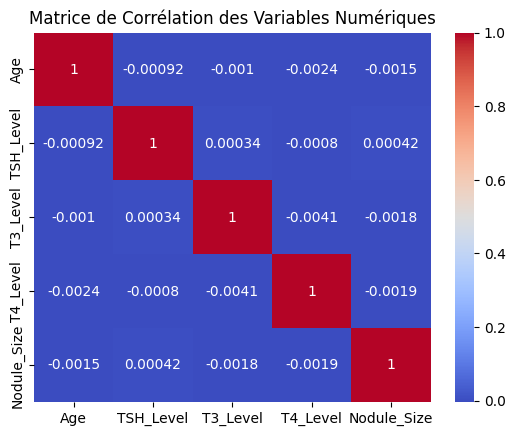

In [117]:
# Relations entre les variables numériques
# Matrice de corrélation (pour les variables numériques)
correlation_matrix = df[numerical_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Matrice de Corrélation des Variables Numériques")
plt.show()

# Aucune correlation visible pour les variables numériques à ce stade.

Il est logique que l'âge n'ait pas de lien avec les autres données.

On pourrait s'attendre par contre à avoir une correlation entre TSH, T3 et T4. En effet, la TSH est l'hormone hypophysaire qui déclenche la production de T3 et T4, et T3 et T4 sont deux formes plus ou moins iodées de la thyronine, et leur régulations sont liées. Elles semblent pourtant totalement indépendantes dans ce dataset.

En cas de déficience en iode il y a augmentation relative de la synthèse de T3 par rapport à T4.

La T4 n'est qu'une forme de stockage de l'iode, la véritable hormone active étant T3

# Analyse des variables cibles : Thyroid_Cancer_Risk et Diagnosis

In [118]:
# Comptage des valeurs dans la colonne 'Thyroid_Cancer_Risk'
counts = df['Thyroid_Cancer_Risk'].value_counts()

# Extraction des valeurs et création de variables pour les calculs
low_count = counts['Low']
medium_count = counts['Medium']
high_count = counts['High']

# Calcul du ratio de chaque colonne par rapport au total
ratio_low = low_count / (low_count+medium_count+high_count)*100
ratio_medium = medium_count / (low_count+medium_count+high_count)*100
ratio_high = high_count / (low_count+medium_count+high_count)*100

# Affichage des résultats
print(f"Nombre de 'low' : {low_count}")
print(f"Nombre de 'medium' : {medium_count}")
print(f"Nombre de 'high' : {high_count}")

print(f"Ratio low : {ratio_low:.2f} %")
print(f"Ratio medium : {ratio_medium:.2f} %")
print(f"Ratio high : {ratio_high:.2f} %")


Nombre de 'low' : 108388
Nombre de 'medium' : 72400
Nombre de 'high' : 31903
Ratio low : 50.96 %
Ratio medium : 34.04 %
Ratio high : 15.00 %


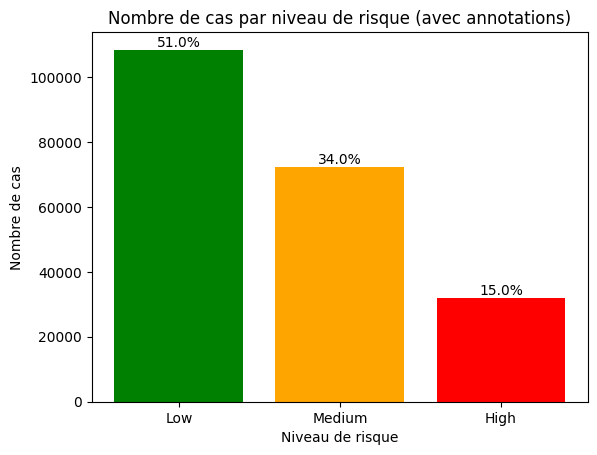

In [119]:
# Graphique à barres avec annotations
bars = plt.bar(['Low', 'Medium', 'High'], [low_count, medium_count, high_count], color=['green', 'orange', 'red'])

# Ajouter des annotations aux barres
for bar, ratio in zip(bars, [ratio_low, ratio_medium, ratio_high]):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{ratio:.1f}%', ha='center', va='bottom')

plt.title("Nombre de cas par niveau de risque (avec annotations)")
plt.xlabel("Niveau de risque")
plt.ylabel("Nombre de cas")
plt.show()

## Pertinence de l'analyse quantitative de la variable cible :

Il était important de mesurer les ratios de chacune des classes de la variable cible, pour éviter un déséquilibre des données d'entrainement. A ce stade, les indicateurs sont au vert, car nous n'avons pas de sur-représentation de la classe Low, ce qui est souvent le cas dans les datasets de pathologies telles que le cancer.

## La courbe ROC ne peut pas être tracée pour des variables comportant 3 modalités, comme la variable Thyroid_Cancer_Risk dans ce dataset.

Je modifierai donc cette variable pour obtenir la courbe ROC, en fusionnant les données medium et High, et en traitant donc la variable en risk versus low_risk

In [120]:
# Remplacement des valeurs dans la cible
df['Thyroid_Cancer_Risk_Binary'] = df['Thyroid_Cancer_Risk'].replace({
    'Low': 0,          # Classe 0 : Pas à risque
    'Medium': 1,       # Classe 1 : À risque
    'High': 1          # Classe 1 : À risque
})

# Vérifie les nouvelles valeurs de la variable cible binaire
print(df['Thyroid_Cancer_Risk_Binary'].value_counts())


Thyroid_Cancer_Risk_Binary
0    108388
1    104303
Name: count, dtype: int64


## Nous avons une bonne répartition des deux catégories, de taille similaire, ce qui est pertinent pour la création d'un modèle

## Analyse de la colonne Diagnosis

Comptages pour la variable 'Diagnosis' :
Diagnosis
Benign       163196
Malignant     49495
Name: count, dtype: int64

Ratios (en pourcentage) pour chaque classe :
Diagnosis
Benign       76.729152
Malignant    23.270848
Name: count, dtype: float64
Tableau structuré pour 'Diagnosis':
   Diagnosis   Count  Percentage
0     Benign  163196   76.729152
1  Malignant   49495   23.270848


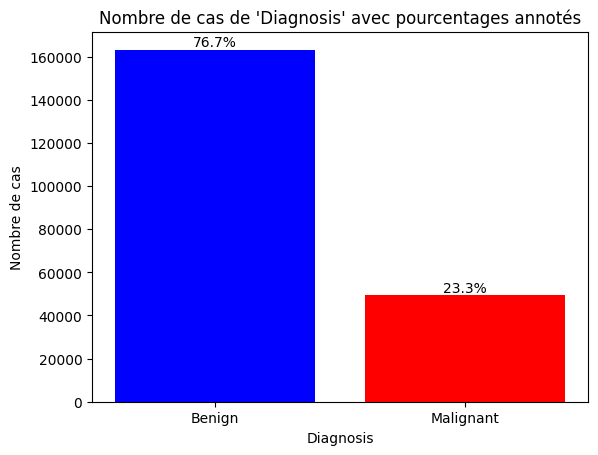

In [121]:
# Comptage des valeurs dans la colonne 'Diagnosis'
diagnosis_counts = df['Diagnosis'].value_counts()  # Comptage brut
total_diagnosis = diagnosis_counts.sum()  # Nombre total d'observations

# Calcul des pourcentages pour chaque classe
diagnosis_ratios = diagnosis_counts / total_diagnosis * 100

# Affichage des résultats
print("Comptages pour la variable 'Diagnosis' :")
print(diagnosis_counts)
print("\nRatios (en pourcentage) pour chaque classe :")
print(diagnosis_ratios)

# Création d'un DataFrame structuré pour les diagnostics
diagnosis_df = pd.DataFrame({
    'Diagnosis': diagnosis_counts.index,  # Les labels (`Benign`, `Malignant`)
    'Count': diagnosis_counts.values,     # Nombre de cas
    'Percentage': diagnosis_ratios.values # Pourcentages correspondants
})

print("Tableau structuré pour 'Diagnosis':")
print(diagnosis_df)

# Création d'un graphique à barres avec annotations
bars = plt.bar(diagnosis_df['Diagnosis'], diagnosis_df['Count'], color=['blue', 'red'])

# Ajouter les annotations sur les pourcentages sur chaque barre
for bar, percentage in zip(bars, diagnosis_df['Percentage']):
    height = bar.get_height()  # Hauteur actuelle de la barre
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{percentage:.1f}%', ha='center', va='bottom')

# Ajouter un titre et étiquettes
plt.title("Nombre de cas de 'Diagnosis' avec pourcentages annotés")
plt.xlabel("Diagnosis")
plt.ylabel("Nombre de cas")
plt.show()

## Analyse comparative Diagnosis et Risk

Il est intéressant de voir que le diagnostic final est catégorisé selon 2 modalités, benin ou malin, alors que le risque est catégorisé selon 3 modalités.

Les pourcentages des deux ne se recoupent pas, donc nous avons une variation entre l'analyse par la machine et celle par le praticien. Les praticiens diagnostiquent presque 24% de cancers, alors que le dataset en présente presque 50% si on cumule les risques medium et high.

Il est pas pertinent de créer un modèle permettant d'évaluer le diagnostic, puisqu'il est dépendant de la pratique des médecins. Il est plus logique de baser nos efforts sur l'analyse du risque. Nous décidons donc de travailler sur Thyroid_Cancer_Risk, en modalité binaire

## Encodage des données catégorielles pour le modèle

In [122]:
#Appliquer One-Hot Encoding à toutes les colonnes catégoriques
X_encoded = pd.get_dummies(X, drop_first=True)  # Garder n-1 colonnes pour éviter la colinéarité

# Convertir tout le DataFrame en int (les booléens deviennent 0/1, les autres restent inchangés)
X_encoded = X_encoded.astype(int)

# Vérifier les types de colonnes après conversion
print(X_encoded.dtypes)


Age                         int64
TSH_Level                   int64
T3_Level                    int64
T4_Level                    int64
Nodule_Size                 int64
Gender_Male                 int64
Country_China               int64
Country_Germany             int64
Country_India               int64
Country_Japan               int64
Country_Nigeria             int64
Country_Russia              int64
Country_South Korea         int64
Country_UK                  int64
Country_USA                 int64
Ethnicity_Asian             int64
Ethnicity_Caucasian         int64
Ethnicity_Hispanic          int64
Ethnicity_Middle Eastern    int64
Family_History_Yes          int64
Radiation_Exposure_Yes      int64
Iodine_Deficiency_Yes       int64
Smoking_Yes                 int64
Obesity_Yes                 int64
Diabetes_Yes                int64
dtype: object


In [124]:
# Afficher les types de chaque colonne du DataFrame
print(df.dtypes)

# Filtrer les colonnes qui ne sont pas numériques
categorical_columns = df.select_dtypes(include=['object']).columns
print("Colonnes catégorielles :", categorical_columns)

Age                             int64
Gender                         object
Country                        object
Ethnicity                      object
Family_History                 object
Radiation_Exposure             object
Iodine_Deficiency              object
Smoking                        object
Obesity                        object
Diabetes                       object
TSH_Level                     float64
T3_Level                      float64
T4_Level                      float64
Nodule_Size                   float64
Thyroid_Cancer_Risk            object
Diagnosis                      object
Thyroid_Cancer_Risk_Binary      int64
dtype: object
Colonnes catégorielles : Index(['Gender', 'Country', 'Ethnicity', 'Family_History',
       'Radiation_Exposure', 'Iodine_Deficiency', 'Smoking', 'Obesity',
       'Diabetes', 'Thyroid_Cancer_Risk', 'Diagnosis'],
      dtype='object')


Forme de X_train : (148883, 25)
Forme de y_train : (148883,)
Forme de X_test : (63808, 25)
Forme de y_test : (63808,)
Accuracy du modèle : 0.6084346790371113
AUC-ROC du modèle : 0.6350419091865038


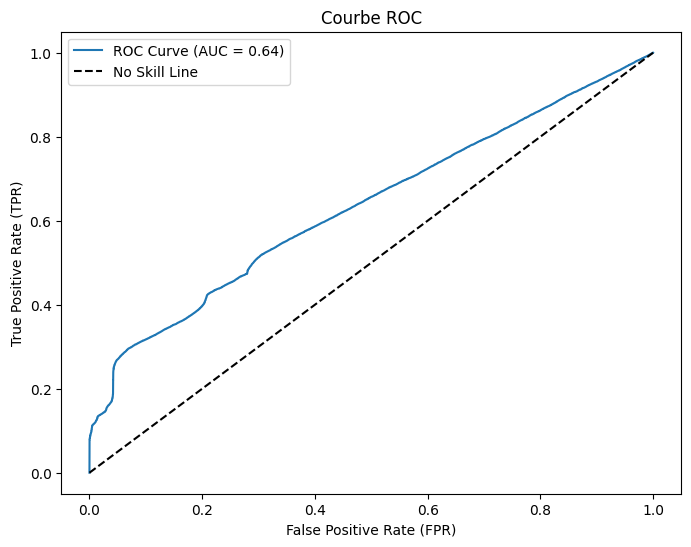

Exemple des probabilités prédictes : [0.39812543 0.3971463  0.7209785  0.42947792 0.62250287 0.46186411
 0.56602286 0.32229943 0.31823046 0.51421423]
Exemple des classes prédites : [0 0 1 0 1 0 1 0 0 1]


In [125]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# --- Étape 1 : Définir la cible et les prédicteurs ---

# Définir la variable cible (y) comme `Thyroid_Cancer_Risk_Binary`
y = df['Thyroid_Cancer_Risk_Binary']

# X est déjà prêt avec `X_encoded`, uniquement des colonnes numériques
X = X_encoded

# --- Étape 2 : Diviser les données en train/test ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Vérifier les dimensions des données après division
print("Forme de X_train :", X_train.shape)
print("Forme de y_train :", y_train.shape)
print("Forme de X_test :", X_test.shape)
print("Forme de y_test :", y_test.shape)

# --- Étape 3 : Entraîner un modèle de régression logistique ---
# Initialiser la régression logistique
model = LogisticRegression(solver='lbfgs', max_iter=1000)

# Entraîner le modèle
model.fit(X_train, y_train)

# --- Étape 4 : Faire des prédictions ---
# Probabilités pour la classe positive (1)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilités de `1` (cancer)

# Classes prédites à partir des probabilités, seuil par défaut = 0.5
y_pred = (y_pred_proba >= 0.5).astype(int)

# --- Étape 5 : Évaluer les performances ---
# Accuracy du modèle
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy du modèle :", accuracy)

# AUC-ROC du modèle
auc_score = roc_auc_score(y_test, y_pred_proba)
print("AUC-ROC du modèle :", auc_score)

# --- Étape 6 : Tracer la courbe ROC ---
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="No Skill Line")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Courbe ROC")
plt.legend()
plt.show()

# --- Étape 7 : Exemple des probabilités et prédictions ---
print("Exemple des probabilités prédictes :", y_pred_proba[:10])
print("Exemple des classes prédites :", y_pred[:10])


# Nous obtenons une aire sous la courbe de 0,64, ce qui n'est pas exceptionnellement performant.

## Les données de départ étant relativement équilibrées, il faut très certainement rajouter des variables au modèle pour améliorer ses performances, ou changer de type de modèle, la regression logistique étant probablement un peu trop linéaire pour ces données.


Matrice de confusion :
 [[48117   842]
 [13261  1588]]


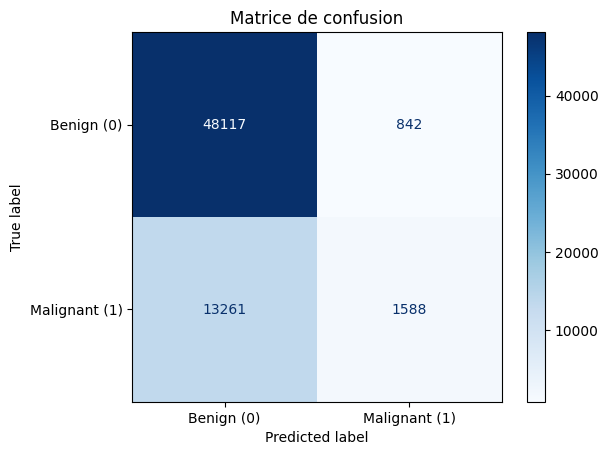

In [88]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# --- Étape 1 : Calculer la matrice de confusion ---
cm = confusion_matrix(y_test, y_pred)  # y_test = label réel, y_pred = prédictions du modèle
print("\nMatrice de confusion :\n", cm)

# --- Étape 2 : Afficher la matrice de confusion sous forme graphique ---
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign (0)", "Malignant (1)"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Matrice de confusion")
plt.show()


# Pour une meilleure interprétablité, je créé le graphique de la matrice de confusion en pourcentages

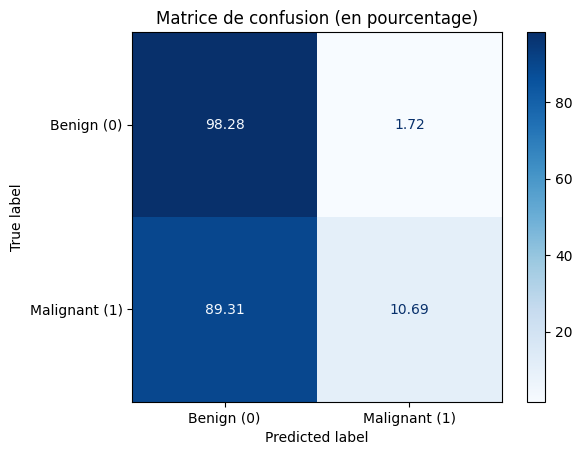

In [89]:
# Convertion de la matrice en pourcentages :
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Affichage :
disp = ConfusionMatrixDisplay(confusion_matrix=cm_percentage, display_labels=["Benign (0)", "Malignant (1)"])
disp.plot(cmap="Blues", values_format=".2f")  # Affichage en pourcentage
plt.title("Matrice de confusion (en pourcentage)")
plt.show()


# Interprétation de la matrice de confusion

Les points pertinents pour le diagnostic de cancer sont les faux positifs et les faux négatifs.

Faux positifs, parce qu'ils exposent des patients à des traitements lourds (chimiothérapie, radiothérapie, ablation de la thyroïde et traitement hormonal à vie).

Faux négatifs, parce que le cancer est à tords diagnostiqué comme bénin alors qu'il mets la vie du patient en danger.

Dans ce cas-ci, la matrice de confusion montre que 1,72% des cancers bénins sont considérés comme malins. Ce chiffre est bas, ce qui expose peu de monde à des traitements lourds non pertinents. Toutefois, il faut donc coupler le modèle préditionnel à une analyse plus poussée. Par exemple une biopsie du nodule avec analyse cytologique pour confirmer la présence de cellules cancéreuses.

Plus grave, par contre, c'est le taux de nodules catégorisés comme bénin alors qu'ils sont malins : 89,31%. Ce qui laisse seulement 10,89% des tumeurs malignes correctement catégorisées par le modèle.

Il est donc plus que fortement conseillé que les patients ayant un nodule cancéreux soient suivis de prés, et que la malinité de leur nodule soit analysée, soit par biopsie, soit par d'autres métriques. Dans ce cas, le modèle ici à nettement besoin d'une amélioration, probablement par l'ajout de données supplémentaires (voir la section "données manquantes" du notebook, à la fin), ou en testant d'autre type de modélisation.

## Analyses complémentaires et données manquantes

Il est pertinent de rajouter les données liées à l'iode, telles que l'iode plasmatique libre, mais surtout les taux d'élimination de l'iode par l'urine, avec la mesure du ratio iode/créatinine urinaire.

La TRH devrait être étudiée également (détection de la maladie de Basedow, hypothyroidie ou hyperthoroidie en lien avec le développement de cancer thyroidien).

La clairance urinaire et la clairance plasmatique de l'iode sont des données physiologiques pertinentes pour la mesure de la bonne santé thyroïdienne.

L'absorbtion de l'iode plasmatique étant liée au sodium, il est aussi pertinent de renseigner le dataset sur l'Hypertension des patients, qui implique souvent des régimes alimentaires hyposodés, et parfois un déficit iodé.

La concentration plasmatiques des proteïnes de transports de la T3 et T4 (la TBG (thyroxine binding globulin) et la TBPA (thyroxine binding prealbumin)) étant influencée par les oestrogènes et les androgènes, il est pertinent de savoir le statut hormonal des femmes du dataset : non ménopausée, préménopause ou ménopause.

Sources : PubMed / Medline + https://www.pharmacorama.com/pharmacologie/hormones-cytokinesantigenes-anticorps/trh-tsh-hormones-thyroidiennes-antithyroidiens-synthese/hormones-thyroidiennes-t4-t3/

# L'AUC de ce modèle étant bas, je teste un random forest

In [126]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Prédictions & AUC
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]
auc_rf = roc_auc_score(y_test, y_pred_proba_rf)
print(f"AUC avec Random Forest : {auc_rf:.2f}")


AUC avec Random Forest : 0.65


# L'Aire sous la courbe ne change pas que ce soit par un Random Forest ou une regression logistique.

Voici la courbe ROC associée au Random Forest sur ce *dataset*

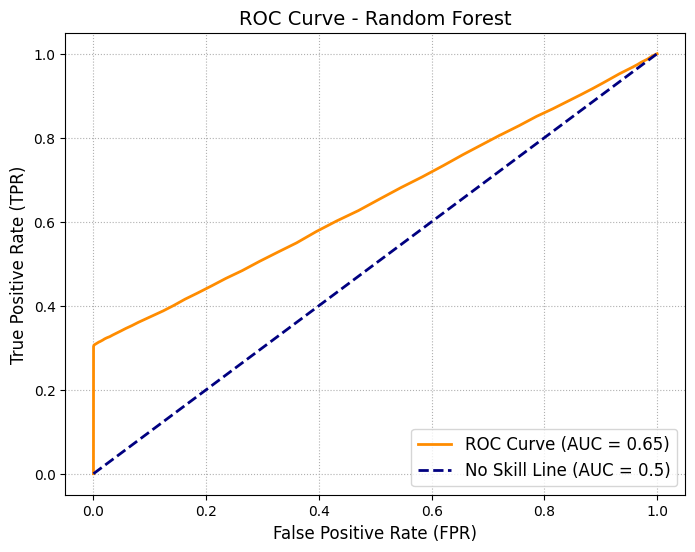

In [127]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# --- Étape 1 : Calculer la courbe ROC ---
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_rf)  # Calcul des FPR et TPR
roc_auc = auc(fpr, tpr)  # Calcul de l'AUC

# --- Étape 2 : Traçage de la courbe ---
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle="--", label="No Skill Line (AUC = 0.5)")

# Ajout des labels et légendes
plt.xlabel("False Positive Rate (FPR)", fontsize=12)
plt.ylabel("True Positive Rate (TPR)", fontsize=12)
plt.title("ROC Curve - Random Forest", fontsize=14)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True, linestyle=":")
plt.show()


NOTE : La forme anguleuse de la courbe est logique, liée aux calculs de probabilités des arbres de décision, alors que la forme arrondie de la courbe ROC de la regression logistique est liée à sa fonction sigmoïde

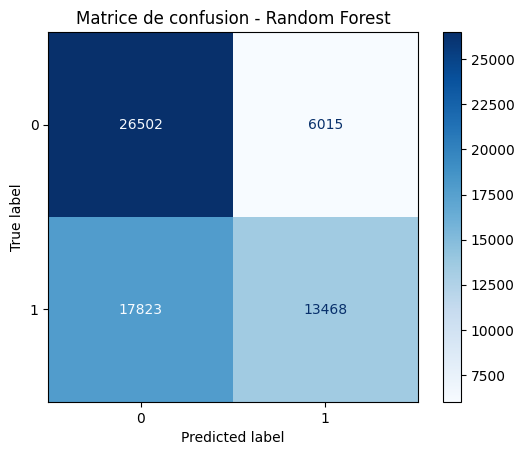

In [128]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# --- Étape 1 : Faire les prédictions sur le set de test ---
y_pred_rf = rf_model.predict(X_test)  # Prédictions discrètes (0 ou 1)

# --- Étape 2 : Calculer la matrice de confusion ---
cm = confusion_matrix(y_test, y_pred_rf)  # compare y_test (vrai) avec y_pred (prévisions)

# --- Étape 3 : Afficher la matrice de confusion ---
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_model.classes_)
disp.plot(cmap='Blues', values_format='d')  # Affichage avec couleur
plt.title("Matrice de confusion - Random Forest")
plt.show()


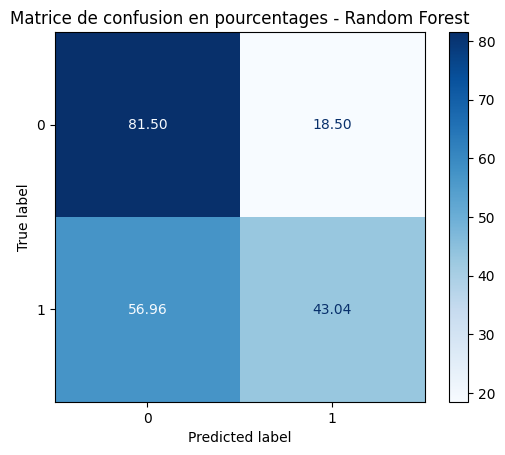

In [129]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# --- Étape 1 : Faire les prédictions ---
y_pred_rf = rf_model.predict(X_test)  # Prédictions discrètes (0 ou 1)

# --- Étape 2 : Calculer la matrice de confusion ---
cm = confusion_matrix(y_test, y_pred_rf)  # Vraies étiquettes vs prédictions

# --- Étape 3 : Convertir en pourcentages ---
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100  # Conversion ligne par ligne

# --- Étape 4 : Afficher la matrice de confusion ---
disp = ConfusionMatrixDisplay(confusion_matrix=cm_percent, display_labels=rf_model.classes_)
disp.plot(cmap='Blues', values_format=".2f")
plt.title("Matrice de confusion en pourcentages - Random Forest")
plt.show()


# La performance du modèle Random Forest est meilleure que la Regression Logistique.

Même si la valeur de l'Aire sous la Courbe est identique, le taux de prédiction de nodules bénins alors qu'ils sont malin est un peu moins important, même s'il frole quand même les 57%.

Par contre, le taux d'attribution à tord de malinité sur des modules bénins passe de 10% à presque 20%.

# Quel que soit le modèle appliqué, il est important d'enrichir le dataset, qui ne permet pas, à ce stade des prédictions suffisamment fiables pour un domaine médical où la précision et la sensibilité doivent être optimisées.